In [59]:
import geopandas as gpd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [60]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Carga de Datos

In [61]:
poblacion_gdf = gpd.read_file("..\Datos\Poblacion\PoblacionAMB_noAdj_ETRS89.shp",encoding='utf-8')
buffers = gpd.read_file("..\Datos\Buffers\Buffers_Conjunto_25_5000.shp")
buffers.sort_values(by='layer',inplace=True)

In [62]:
poblacion_gdf.head()

,fid,Poblacion,geometry
0,1.0,4,"POLYGON ((3668749.894 2086123.786, 3668831.902..."
1,2.0,6,"POLYGON ((3668585.877 2086041.778, 3668667.885..."
2,3.0,5,"POLYGON ((3668585.877 2086205.795, 3668667.885..."
3,4.0,8,"POLYGON ((3668093.825 2085877.761, 3668175.834..."
4,5.0,13,"POLYGON ((3668093.825 2085795.752, 3668175.834..."


In [63]:
poblacion_gdf['Poblacion'].sum()

2572656

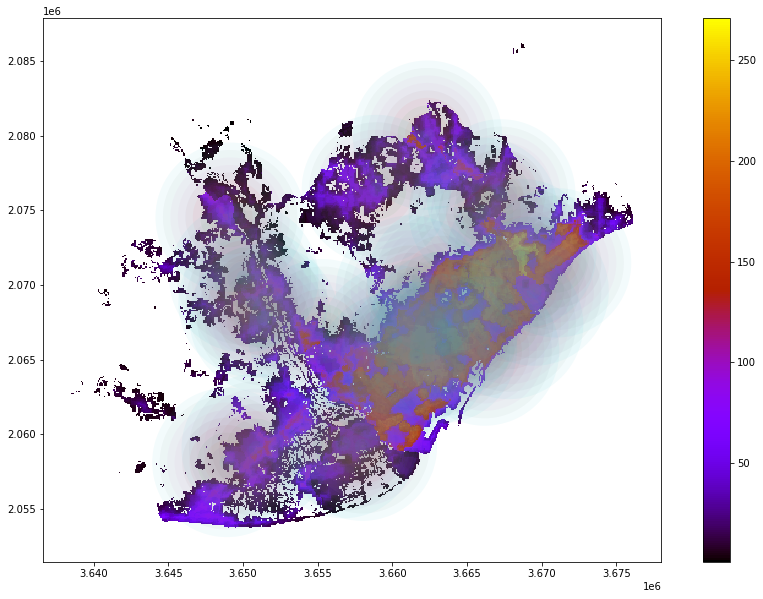

In [64]:
f, ax = plt.subplots(1,1,figsize=(15,10))
poblacion_gdf.plot(column='Poblacion', ax=ax, legend=True,cmap="gnuplot")
buffers.plot(column='layer',ax=ax, alpha=0.05)
plt.show()

# Calculo Poblacion por buffer

Definir lista de buffers, estaciones y codigos de estaciones:

In [65]:
buf = ['b25','b50','b100','b300','b500','b1000', 'b1500', 'b2000','b2500', 'b3000','b3500', 'b4000','b4500','b5000']
est = list(buffers['NOM ESTACI'].unique())
est_cod = list(buffers['CODI EOI'].unique())

In [73]:
# Definición DF donde se pegarán los datos de longitud:
dfBufPoblacion=pd.DataFrame(est_cod,columns=['CODI EOI'])
dfBufPoblacion['ESTACION'] = est
# Calculo
for i,v in enumerate(buf):
    print(f'{i+1} - Procesando {v}...')
    # Filtrar buffers
    df_buffer = buffers[buffers['layer']== v ]
    # Intersección Usos Suelo y buffer
    df_aux = gpd.overlay(poblacion_gdf, df_buffer, how='intersection')
    # Agrupación por Codigo Estación y Clase de Uso Suelo - Suma longitud Carretera
    df_aux1 = df_aux.groupby(by=['CODI EOI']).sum('Poblacion').reset_index(drop=False)
    df_aux1['buffer'] = v
    df_aux1 = df_aux1[['CODI EOI','buffer','Poblacion']]
    # Spread de columnas
    df_aux1 = pd.crosstab(index=df_aux1['CODI EOI'],
                          columns=df_aux1['buffer'],
                          values=df_aux1['Poblacion'],
                          aggfunc='mean').reset_index(drop=False)
    # Join con dfBufCar
    dfBufPoblacion = dfBufPoblacion.merge(df_aux1, how='left',on='CODI EOI')
# Substituir NaN por 0
dfBufPoblacion = dfBufPoblacion.replace(np.nan, 0)
# Ordenar DF por Codigo EOI
dfBufPoblacion.sort_values(by='CODI EOI',inplace=True).reset_index(drop=True,inplace=True)

1 - Procesando b25...
2 - Procesando b50...
3 - Procesando b100...
4 - Procesando b300...
5 - Procesando b500...
6 - Procesando b1000...
7 - Procesando b1500...
8 - Procesando b2000...
9 - Procesando b2500...
10 - Procesando b3000...
11 - Procesando b3500...
12 - Procesando b4000...
13 - Procesando b4500...
14 - Procesando b5000...


In [80]:
dfBufPoblacion.to_csv('..\Datos\Datos_Procesados\Estacion_Buffers_Poblacion_worldpop_noAdj.csv')